In [94]:
import os
import numpy as np
import pandas as pd
import pickle
import sklearn.linear_model
from sklearn.model_selection import GridSearchCV
import sklearn.pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm

# Import our custom functions
from load_data import load_data 

In [2]:
x_tr, y_tr_df = load_data('x_train.csv', 'y_train.csv')
x_va, y_va_df = load_data('x_valid.csv', 'y_valid.csv')
x_te = load_data('x_test.csv', 'y_valid.csv')[0]


for label, arr in [('train', x_tr), ('valid', x_va)]:
    print("Contents of %s_x.csv: arr of shape %s" % (
        label, str(arr.shape)))

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


# Model with Duplicate Data

In [3]:
#getting index for each class in training set:
top_int = y_tr_df.index[y_tr_df['class_name']=='top']    #index 1
trous_int = y_tr_df.index[y_tr_df['class_name']=='trouser']    #index 11
dress_int =(y_tr_df.index[y_tr_df['class_name']=='dress']).tolist()
pull_int =(y_tr_df.index[y_tr_df['class_name']=='pullover']).tolist()
sneaker_int =(y_tr_df.index[y_tr_df['class_name']=='sneaker']).tolist()
sandal_int =(y_tr_df.index[y_tr_df['class_name']=='sandal']).tolist()


#sneakers + sandals + tops + trous + dress + pullovers in new dataset.
train_x_2 = np.vstack((x_tr[sandal_int, :], x_tr[sneaker_int, :]))
tops800= np.tile(x_tr[top_int, :], (800, 1)) #make 800 copies of tops
train_x_2 = np.vstack((train_x_2, tops800)) # add 800 tops to sandals + sneakers
assert(train_x_2.shape == (2400, 784))  #checking dimensions

trous800 = np.tile(x_tr[trous_int, :], (800, 1))  #800 copies of trousers
train_x_2 = np.vstack((train_x_2, trous800)) # add 800 trousers
assert(train_x_2.shape == (3200, 784))  #checking dimensions

dress800 = np.tile(x_tr[dress_int, :], (2, 1))   #doubled dresses 400 to 800
assert(dress800.shape == (800, 784))
train_x_2 = np.vstack((train_x_2, dress800)) # add 800 dresses
assert(train_x_2.shape == (4000, 784))  #checking dimensions

pull800 = np.tile(x_tr[pull_int, :], (8, 1))
assert(pull800.shape == (800, 784))
train_x_2 = np.vstack((train_x_2, pull800)) # add 800 dresses
assert(train_x_2.shape == (4800, 784))

#making train_y_2
train_y_2 = np.tile(7, 800) 
train_y_2 = np.hstack((train_y_2, np.tile(5, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(0, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(1, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(3, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(2, 800)))

assert(train_y_2.shape == (4800, ))


In [4]:
# Combine training and validation datasets
x_dup_all = np.vstack((train_x_2, x_va))
y_dup_all = np.hstack((train_y_2, y_va_df['class_uid']))

print("Training X shape: %s\nValidation X shape: %s\nCombined X shape: %s\n" % (train_x_2.shape, x_va.shape, x_dup_all.shape))
print("Training Y shape: %s\nValidation Y shape: %s\nCombined Y shape: %s\n" % (train_y_2.shape, y_va_df['class_uid'].shape, y_dup_all.shape))

valid_dup_indicators = np.hstack([
    -1 * np.ones(train_y_2.shape[0]), #-1 = exclude this example in test split
    0 * np.ones(y_va_df.shape[0]), #0 = include in the first test split
    ])

# Define custom splitter to use only the validation dataset for hyperparameter selection
print("Splitter dimensions: %i" % (valid_dup_indicators.shape[0]))
my_dup_splitter = sklearn.model_selection.PredefinedSplit(valid_dup_indicators)

Training X shape: (4800, 784)
Validation X shape: (600, 784)
Combined X shape: (5400, 784)

Training Y shape: (4800,)
Validation Y shape: (600,)
Combined Y shape: (5400,)

Splitter dimensions: 5400


## Initial Grid Search

In [119]:
flag = 'run'
grid_1_filename = '1D_initial_gridSearch.sav'

if os.path.isfile("./" + grid_1_filename) and flag != 'run':
    grid_dup_fashion_pipes = pickle.load(open(grid_1_filename, 'rb'))
else:
    #batch size only for non-lbfgs. 
    #Learning Rate = const, adaptive, etc... ONLY for sgd
    #early_stopping only for sgd/adam.

    #SAY uniform sampling of 
    grid_params = dict(activation = ['identity', 'relu'], alpha = np.logspace(-5, 5, 10), max_iter = [4, 16, 64, 128], hidden_layer_sizes=[(10,), (20,), (50,), (100,)])

    grid_dup_fashion_pipes = sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('grid_search', GridSearchCV(sklearn.neural_network.MLPClassifier   
                                     (solver='lbfgs', shuffle=True, random_state=0), grid_params, scoring='balanced_accuracy', error_score='raise', return_train_score=True, cv= my_dup_splitter, refit= False))
    ])

    grid_dup_fashion_pipes.fit(x_dup_all, y_dup_all)
    pickle.dump(grid_dup_fashion_pipes, open(grid_1_filename, 'wb'))

In [66]:
#loading the pickled modle!
load_initial = pickle.load(open(grid_1_filename, 'rb'))
result = load_initial['grid_search'].cv_results_['rank_test_score']

In [67]:
best_index= np.argsort(result)[:10]
for i in best_index:
    train_score = load_initial['grid_search'].cv_results_['mean_train_score'][i]
    score =load_initial['grid_search'].cv_results_['mean_test_score'][i]
    params = load_initial['grid_search'].cv_results_['params'][i]
    print("mean_train_score: %f" % (train_score), "mean_test_score: %f" % (score), "params: %s" %params)
# the BEST score 0.71333 mean test
# mean_train_score: 0.837917 mean_test_score: 0.713333 params: {'alpha': 599.4842503189421, 'hidden_layer_sizes': (50,), 'max_iter': 4}


mean_train_score: 0.837917 mean_test_score: 0.713333 params: {'alpha': 599.4842503189421, 'hidden_layer_sizes': (50,), 'max_iter': 4}
mean_train_score: 0.826875 mean_test_score: 0.705000 params: {'alpha': 0.2782559402207126, 'hidden_layer_sizes': (50,), 'max_iter': 4}
mean_train_score: 0.826875 mean_test_score: 0.705000 params: {'alpha': 46.41588833612782, 'hidden_layer_sizes': (50,), 'max_iter': 4}
mean_train_score: 0.826875 mean_test_score: 0.705000 params: {'alpha': 0.0016681005372000592, 'hidden_layer_sizes': (50,), 'max_iter': 4}
mean_train_score: 0.826875 mean_test_score: 0.705000 params: {'alpha': 0.0001291549665014884, 'hidden_layer_sizes': (50,), 'max_iter': 4}
mean_train_score: 0.826875 mean_test_score: 0.705000 params: {'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'max_iter': 4}
mean_train_score: 0.826875 mean_test_score: 0.705000 params: {'alpha': 3.593813663804626, 'hidden_layer_sizes': (50,), 'max_iter': 4}
mean_train_score: 0.826875 mean_test_score: 0.705000 params: {'al

## Second Grid Search

In [86]:
flag = 'run'
filename = '1D_2nd_gridSearch.sav'

if os.path.isfile("./" + filename) and flag != 'run':
    grid_dup_fashion_pipes2 = pickle.load(open(filename, 'rb'))
else:
    grid_params2 = dict(alpha = np.logspace(-2, 3, 50), random_state=[1, 2, 3, 4, 5], hidden_layer_sizes = [(19, ), (20, ), (21, ), (49, ), (50, ), (51,)])

    grid_dup_fashion_pipes2 = sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('gridd_search', GridSearchCV(sklearn.neural_network.MLPClassifier (activation='identity', solver='lbfgs', shuffle=True, random_state=0, max_iter = 4), grid_params2, scoring='balanced_accuracy', error_score='raise', return_train_score=True, cv= my_dup_splitter, refit= False))
    ])

    grid_dup_fashion_pipes2.fit(x_dup_all, y_dup_all)
    
    pickle.dump(grid_dup_fashion_pipes2, open(filename, 'wb'))

c:\Users\leigh\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\leigh\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\leigh\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs faile

In [87]:
#loading the pickled modle!
load_2nd = pickle.load(open(filename, 'rb'))
second_result = load_2nd['gridd_search'].cv_results_['rank_test_score']

In [88]:
best_index= np.argsort(second_result)[0:10]

for i in best_index:
    train_score = load_2nd['gridd_search'].cv_results_['mean_train_score'][i]
    score =load_2nd['gridd_search'].cv_results_['mean_test_score'][i]
    params = load_2nd['gridd_search'].cv_results_['params'][i]
    print("mean_train_score: %f" % (train_score), "mean_test_score: %f" % (score), "params: %s" %params)


mean_train_score: 0.811042 mean_test_score: 0.728333 params: {'alpha': 0.032374575428176434, 'hidden_layer_sizes': (21,), 'random_state': 2}
mean_train_score: 0.811042 mean_test_score: 0.728333 params: {'alpha': 0.012648552168552958, 'hidden_layer_sizes': (21,), 'random_state': 2}
mean_train_score: 0.811042 mean_test_score: 0.728333 params: {'alpha': 9.102981779915218, 'hidden_layer_sizes': (21,), 'random_state': 2}
mean_train_score: 0.811042 mean_test_score: 0.728333 params: {'alpha': 3.5564803062231287, 'hidden_layer_sizes': (21,), 'random_state': 2}
mean_train_score: 0.811042 mean_test_score: 0.728333 params: {'alpha': 0.2682695795279726, 'hidden_layer_sizes': (21,), 'random_state': 2}
mean_train_score: 0.811042 mean_test_score: 0.728333 params: {'alpha': 0.5428675439323859, 'hidden_layer_sizes': (21,), 'random_state': 2}
mean_train_score: 0.811042 mean_test_score: 0.728333 params: {'alpha': 1.0985411419875584, 'hidden_layer_sizes': (21,), 'random_state': 2}
mean_train_score: 0.8110

## Random Search

In [115]:
Ran_filename = '1D_RanSearch.sav'
flag = 'run'
if os.path.isfile("./" + Ran_filename) and flag != 'run':
    ran_dup_fashion_pipes = pickle.load(open(filename, 'rb'))
else:
    distEvalHype = dict(alpha = np.random.normal(0.003237, 0.001, 10))

    ran_dup_fashion_pipes = sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('ran_search', RandomizedSearchCV(sklearn.neural_network.MLPClassifier
                                (activation='identity', solver='lbfgs', shuffle=True, random_state=2, max_iter = 4, hidden_layer_sizes = (21,)), distEvalHype,
                                scoring='balanced_accuracy', error_score='raise',
                                return_train_score=True, cv= my_dup_splitter, n_jobs = -1, refit= False))
    ])
    
    ran_dup_fashion_pipes.fit(x_dup_all, y_dup_all)

In [117]:
#loading the pickled modle!
load_low_ran = pickle.load(open('1D_RanSearch.sav', 'rb'))
result = load_low_ran['ran_search'].cv_results_

In [118]:
best_ran_index= np.argsort(load_low_ran['ran_search'].cv_results_['rank_test_score'])
for i in best_ran_index:
    low_ran_train = load_low_ran['ran_search'].cv_results_['mean_test_score'][i]
    low_ran_score =load_low_ran['ran_search'].cv_results_['mean_test_score'][i]
    low_ran_params = load_low_ran['ran_search'].cv_results_['params'][i]

    print("mean_train_score: %f" % (low_ran_train), "mean_test_score: %f" % (low_ran_score), "mean_test_score: %f" % (low_ran_score), "params: %s" %low_ran_params)


mean_train_score: 0.728333 mean_test_score: 0.728333 mean_test_score: 0.728333 params: {'alpha': 0.003670950473480487}
mean_train_score: 0.728333 mean_test_score: 0.728333 mean_test_score: 0.728333 params: {'alpha': 0.003464435024516954}
mean_train_score: 0.728333 mean_test_score: 0.728333 mean_test_score: 0.728333 params: {'alpha': 0.002250320195123119}
mean_train_score: 0.728333 mean_test_score: 0.728333 mean_test_score: 0.728333 params: {'alpha': 0.003864566283304376}
mean_train_score: 0.728333 mean_test_score: 0.728333 mean_test_score: 0.728333 params: {'alpha': 0.00301406557682573}
mean_train_score: 0.728333 mean_test_score: 0.728333 mean_test_score: 0.728333 params: {'alpha': 0.0033186295805596256}
mean_train_score: 0.728333 mean_test_score: 0.728333 mean_test_score: 0.728333 params: {'alpha': 0.0029090603795479727}
mean_train_score: 0.728333 mean_test_score: 0.728333 mean_test_score: 0.728333 params: {'alpha': 0.0033801905190494934}
mean_train_score: 0.728333 mean_test_score: 0.

In [ ]:
#alpha = 1e-05, learning_rate_init = 0.001, max_iter =10, random_state = 2

In [ ]:
best_model = sklearn.pipeline.Pipeline([
    ('scaling', MinMaxScaler()),
    ('model', MLPClassifier(activation='identity', solver='lbfgs', learning_rate= 'constant', shuffle=True, early_stopping = True, random_state=2, hidden_layer_sizes = (20, ), alpha = 1917.910261672485, learning_rate_init = 58.57020818056661, max_iter = 4))
])

best_model['model'].fit(x_dup_all, y_dup_all)

c:\Users\leigh\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


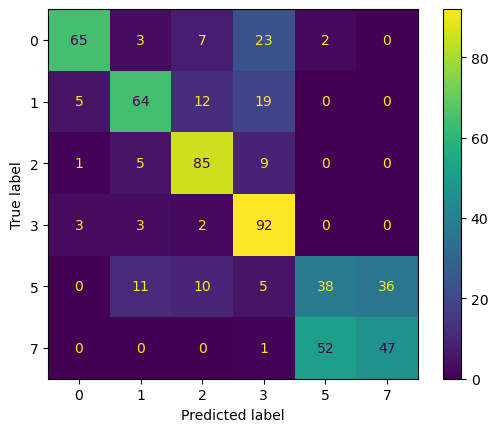

In [ ]:
ConfusionMatrixDisplay.from_estimator(final, x_va, y_va_df['class_uid'])

#id_label = dict(labels = {'dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker'}, class_id = {3, 2, 0, 1, 5, 7})

In [ ]:
yhat = final.predict(x_va)
balanced_accuracy_score(yhat, y_va_df['class_uid'])

0.6586802080851709